In [ ]:
!pip3 install lightly

In [ ]:
import os
import torch
import torch.nn as nn
import torchvision
import pytorch_lightning as pl
import lightly
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
from PIL import Image
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path_to_data = '/content/drive/MyDrive/RHEED'
PATH = '/content/drive/Mydrive/'

In [ ]:
import lightly.data as data

# the collate function applies random transforms to the input images
collate_fn = data.ImageCollateFunction(input_size=32, cj_prob=0.5)

In [ ]:
# create a dataset from your image folder
dataset = data.LightlyDataset(input_dir= path_to_data)

# build a PyTorch dataloader
dataloader = torch.utils.data.DataLoader(
    dataset,                # pass the dataset to the dataloader
    batch_size=128,         # a large batch size helps with the learning
    shuffle=True,           # shuffling is important!
    collate_fn=collate_fn)  # apply transformations to the input images

In [ ]:
num_workers = 2
batch_size = 128
seed = 1
max_epochs = 50
input_size = 256
num_ftrs = 32

In [ ]:
#!rm -R /content/drive/MyDrive/RHEED/.ipynb_checkpoints

In [ ]:
collate_fn = lightly.data.SimCLRCollateFunction(
    input_size=input_size,
    vf_prob=0.5,
    rr_prob=0.5
)

# We create a torchvision transformation for embedding the dataset after
# training
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=lightly.data.collate.imagenet_normalize['mean'],
        std=lightly.data.collate.imagenet_normalize['std'],
    )
])

dataset_train_simclr = lightly.data.LightlyDataset(
    input_dir=path_to_data
)

dataset_test = lightly.data.LightlyDataset(
    input_dir=path_to_data,
    transform=test_transforms
)

dataloader_train_simclr = torch.utils.data.DataLoader(
    dataset_train_simclr,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    drop_last=True,
    num_workers=num_workers
)

dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [ ]:
from lightly.models.modules.heads import SimCLRProjectionHead
from lightly.loss import NTXentLoss


class SimCLRModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # create a ResNet backbone and remove the classification head
        resnet = torchvision.models.resnet18()
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])

        hidden_dim = resnet.fc.in_features
        self.projection_head = SimCLRProjectionHead(hidden_dim, hidden_dim, 128)

        self.criterion = NTXentLoss()

    def forward(self, x):
        h = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(h)
        return z

    def training_step(self, batch, batch_idx):
        (x0, x1), _, _ = batch
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        self.log("train_loss_ssl", loss)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.SGD(
            self.parameters(), lr=6e-2, momentum=0.9, weight_decay=5e-4
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optim, max_epochs
        )
        return [optim], [scheduler]

In [ ]:
model = torch.load('/content/drive/MyDrive/model.pt')

In [ ]:
device='cpu'

In [ ]:
embeddings = []
filenames = []

# disable gradients for faster calculations
model.eval()
with torch.no_grad():
    for i, (x, _, fnames) in enumerate(dataloader_test):
        # move the images to the gpu
        x = x.to(device)
        # embed the images with the pre-trained backbone
        y = model.backbone(x).flatten(start_dim=1)
        # store the embeddings and filenames in lists
        embeddings.append(y)
        filenames = filenames + list(fnames)

# concatenate the embeddings and convert to numpy
embeddings = torch.cat(embeddings, dim=0)
embeddings = embeddings.cpu().numpy()

In [ ]:
# for plotting
import os
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.offsetbox as osb
from matplotlib import rcParams as rcp

# for resizing images to thumbnails
import torchvision.transforms.functional as functional

# for clustering and 2d representations
from sklearn import random_projection

In [ ]:
# for the scatter plot we want to transform the images to a two-dimensional
# vector space using a random Gaussian projection
projection = random_projection.GaussianRandomProjection(n_components=2)
embeddings_2d = projection.fit_transform(embeddings)

# normalize the embeddings to fit in the [0, 1] square
M = np.max(embeddings_2d, axis=0)
m = np.min(embeddings_2d, axis=0)
embeddings_2d = (embeddings_2d - m) / (M - m)

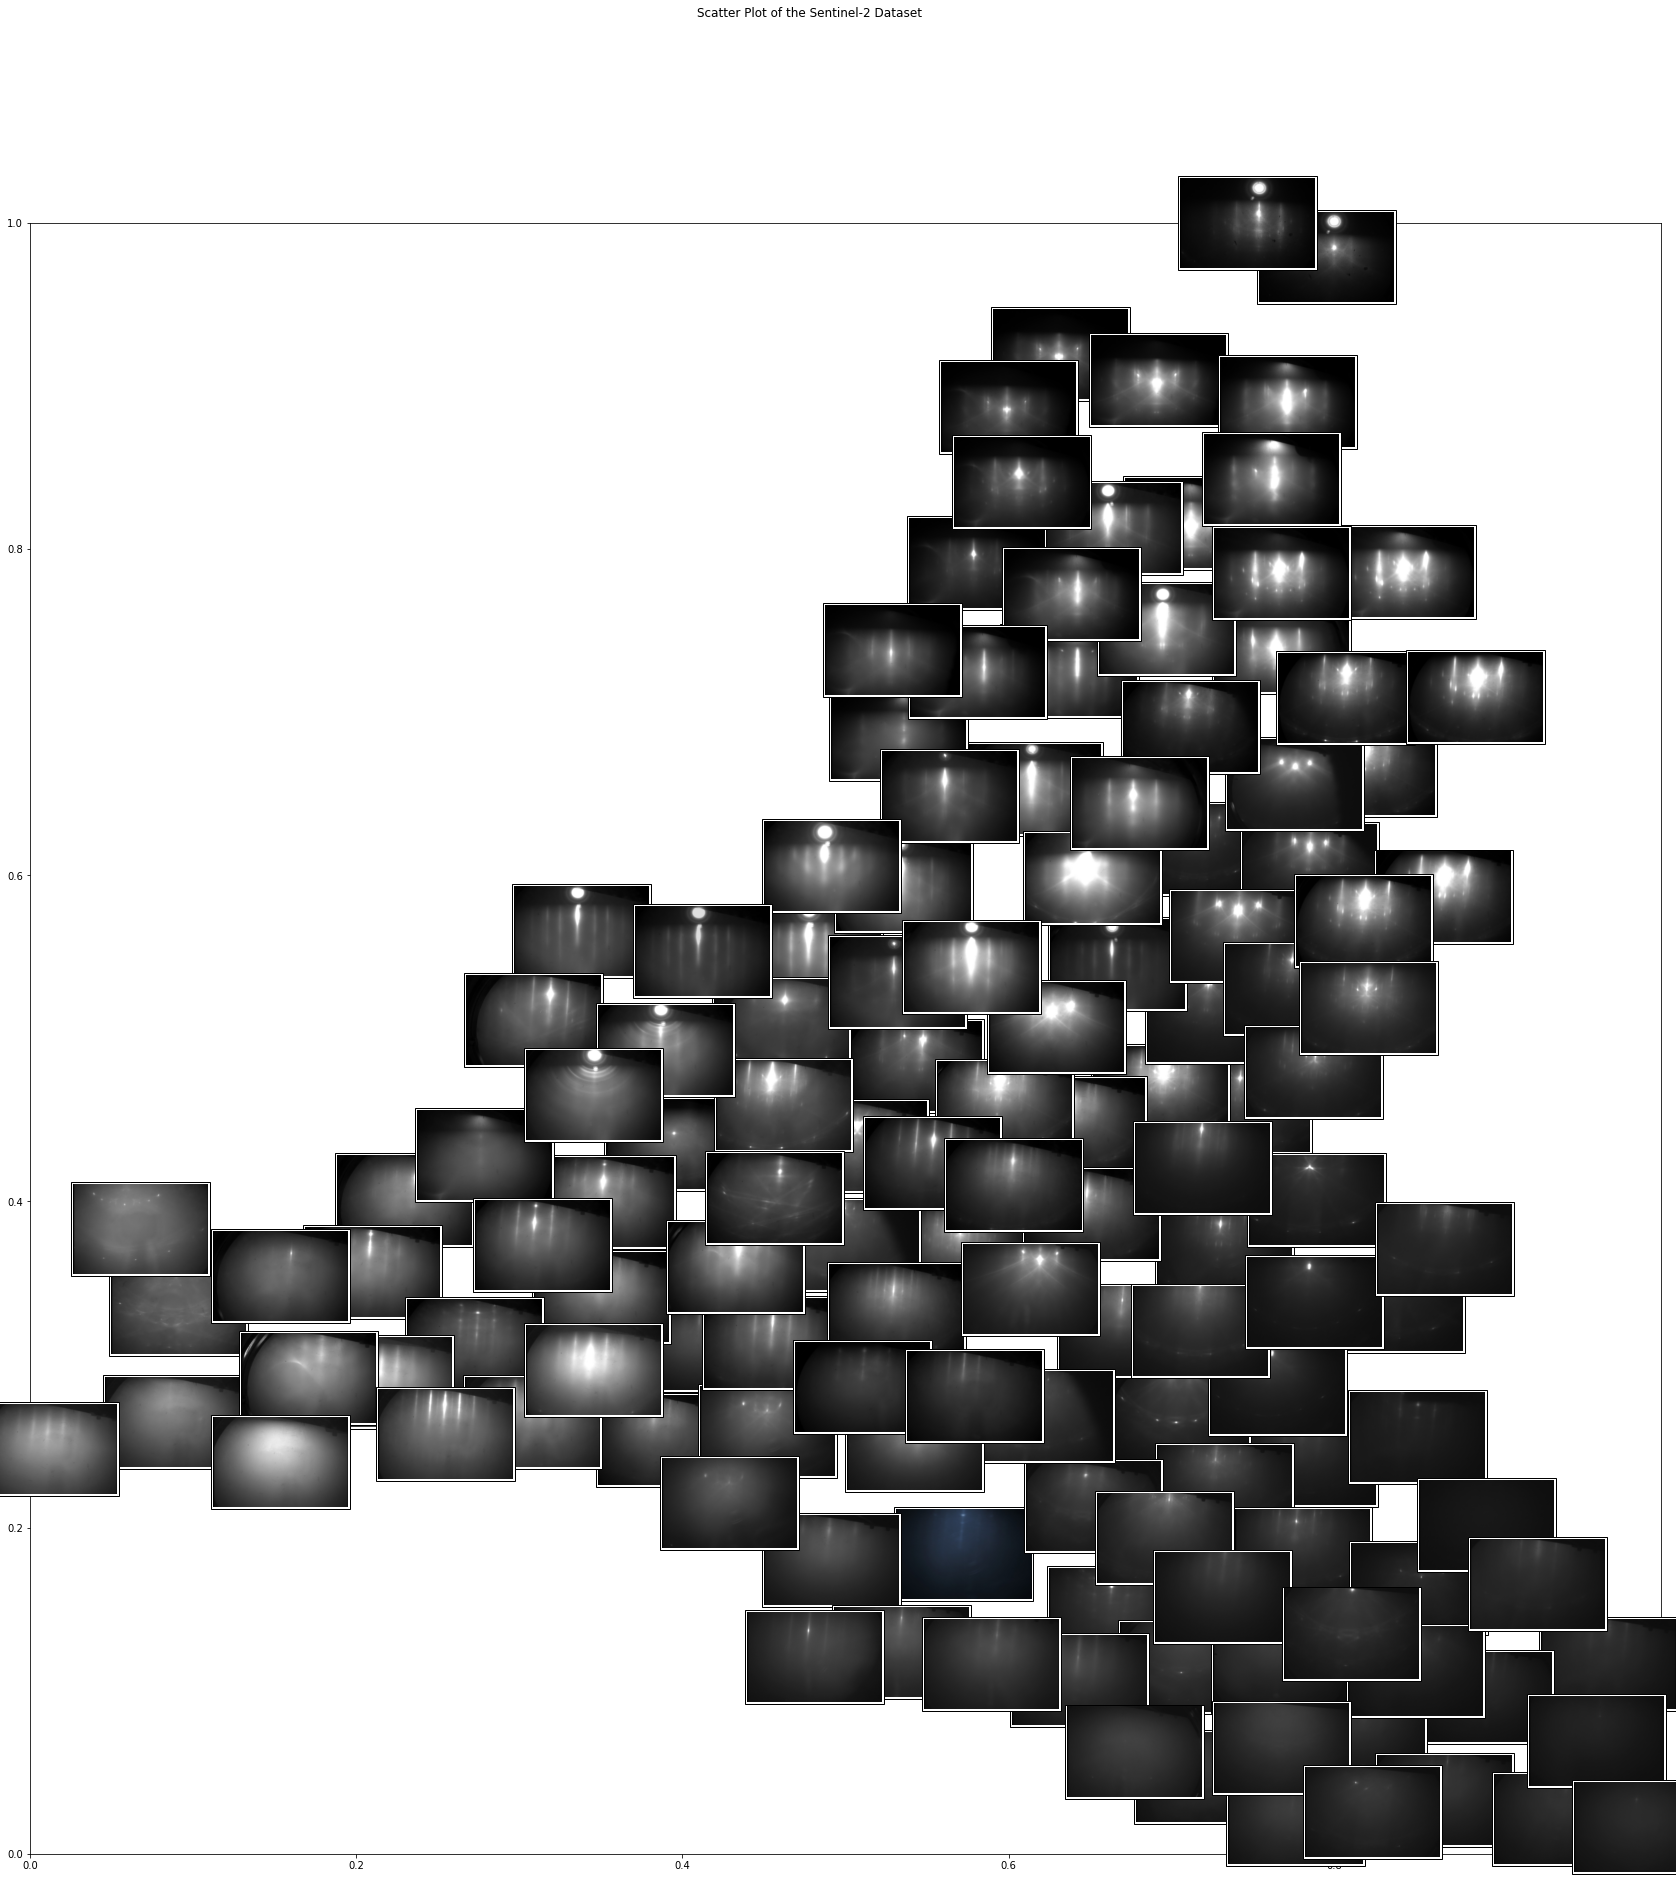

In [ ]:
def get_scatter_plot_with_thumbnails():
    """Creates a scatter plot with image overlays.
    """
    # initialize empty figure and add subplot
    
    fig = plt.figure()
    fig.set_size_inches(40,30)

    fig.suptitle('Scatter Plot of the Sentinel-2 Dataset')
    ax = fig.add_subplot(1, 1, 1)
    # shuffle images and find out which images to show
    shown_images_idx = []
    shown_images = np.array([[1., 1.]])
    iterator = [i for i in range(embeddings_2d.shape[0])]
    np.random.shuffle(iterator)
    for i in iterator:
        # only show image if it is sufficiently far away from the others
        dist = np.sum((embeddings_2d[i] - shown_images) ** 2, 1)
        if np.min(dist) < 2e-3:
            continue
        shown_images = np.r_[shown_images, [embeddings_2d[i]]]
        shown_images_idx.append(i)

    # plot image overlays
    for idx in shown_images_idx:
        thumbnail_size = int(rcp['figure.figsize'][0] * 15.)
        path = os.path.join(path_to_data, filenames[idx])
        img = Image.open(path)
        img = functional.resize(img, thumbnail_size)
        img = np.array(img)
        img_box = osb.AnnotationBbox(
            osb.OffsetImage(img, cmap=plt.cm.gray_r),
            embeddings_2d[idx],
            pad=0.2,
        )
        ax.add_artist(img_box)

    # set aspect ratio
    ratio = 1. / ax.get_data_ratio()
    ax.set_aspect(ratio, adjustable='box')


# get a scatter plot with thumbnail overlays
get_scatter_plot_with_thumbnails()

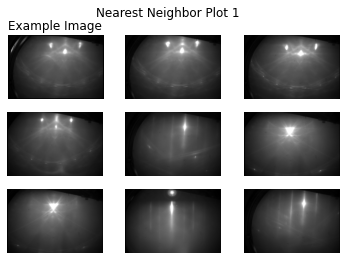

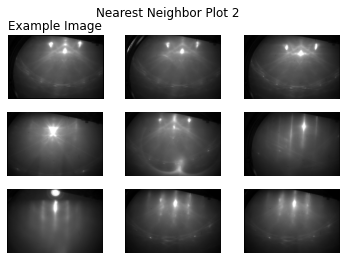

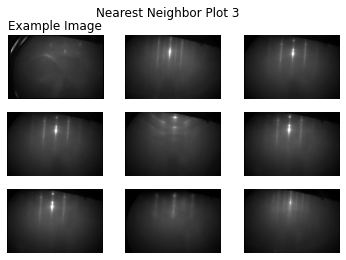

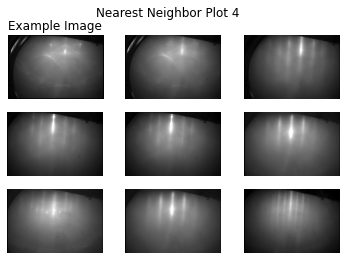

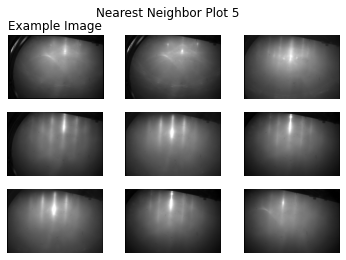

In [ ]:
example_images = [
    '0109_19시06분_Video증착전.jpg', # water 1
    '0109_18시42분_Video600도어닐후.jpg', # water 2
    '0109_19시07분_Video증착1분.jpg', # land
    '0109_19시08분_Video증착2분.jpg', # clouds 1
    '0109_19시09분_Video증착3분.jpg', # clouds 2
]


def get_image_as_np_array(filename: str):
    """Loads the image with filename and returns it as a numpy array.

    """
    img = Image.open(filename)
    return np.asarray(img)


def get_image_as_np_array_with_frame(filename: str, w: int = 5):
    """Returns an image as a numpy array with a black frame of width w.

    """
    img = get_image_as_np_array(filename)
    ny, nx, _ = img.shape
    # create an empty image with padding for the frame
    framed_img = np.zeros((w + ny + w, w + nx + w, 3))
    framed_img = framed_img.astype(np.uint8)
    # put the original image in the middle of the new one
    framed_img[w:-w, w:-w] = img
    return framed_img


def plot_nearest_neighbors_3x3(example_image: str, i: int):
    """Plots the example image and its eight nearest neighbors.

    """
    n_subplots = 9
    # initialize empty figure
    fig = plt.figure()
    fig.suptitle(f"Nearest Neighbor Plot {i + 1}")
    #
    example_idx = filenames.index(example_image)
    # get distances to the cluster center
    distances = embeddings - embeddings[example_idx]
    distances = np.power(distances, 2).sum(-1).squeeze()
    # sort indices by distance to the center
    nearest_neighbors = np.argsort(distances)[:n_subplots]
    # show images
    for plot_offset, plot_idx in enumerate(nearest_neighbors):
        ax = fig.add_subplot(3, 3, plot_offset + 1)
        # get the corresponding filename
        fname = os.path.join(path_to_data, filenames[plot_idx])
        if plot_offset == 0:
            ax.set_title(f"Example Image")
            plt.imshow(get_image_as_np_array_with_frame(fname))
        else:
            plt.imshow(get_image_as_np_array(fname))
        # let's disable the axis
        plt.axis("off")


# show example images for each cluster
for i, example_image in enumerate(example_images):
    plot_nearest_neighbors_3x3(example_image, i)

# Show the Results